# Imperfect Semantic Segmentation

In the real world, we won't have a perfect SS as a input to our model. Thus, it makes sense to try, a priori, a model trained with corrupted semantic segmentation images. This is a way to do this.

In [1]:
import cv2
import numpy as np

def apply_boundary_blur(image_path, blur_radius, save=False):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect edges using Canny
    edges = cv2.Canny(gray, 100, 200)
    
    # Dilate the edge lines to make the boundaries thicker
    dilation_kernel = np.ones((3,3), np.uint8)
    edges_dilated = cv2.dilate(edges, dilation_kernel, iterations=1)
    
    # Create a mask where the edges are
    mask = edges_dilated > 0
    
    # Apply Gaussian blur to the original image
    blurred = cv2.GaussianBlur(image, (blur_radius, blur_radius), 0)
    
    # Combine the original and blurred images using the mask
    image[mask] = blurred[mask]
    
    # Save the result
    if save:
        output_path = 'corrupted_' + image_path.split('/')[-1]
        cv2.imwrite(output_path, image)

        return image, output_path
    return image

In [12]:
# Set the path to your semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Apply the boundary blur with the desired radius
image = apply_boundary_blur(image_path, blur_radius=15)

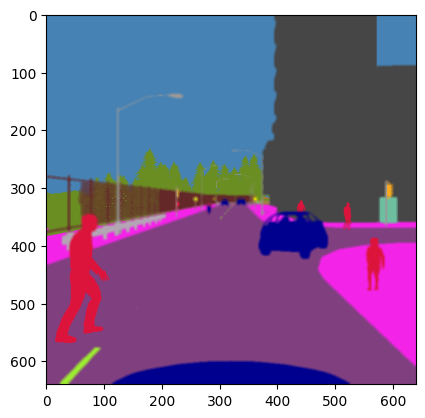

In [13]:
import matplotlib.pyplot as plt

# Let's view the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
# Let's make a grid of plots for different kernel sizes of the 
# Gaussian blur
import scipy.ndimage

sigmas = [0, 1, 5, 10, 20, 50, 100]

def blur_image(img, sigma=1):
    return scipy.ndimage.gaussian_filter(img, sigma=sigma)

for sigma in sigmas:
    blurred = blur_image(stack, sigma=sigma)
    plt.figure(figsize=(15, 5))
    plt.imshow(blurred, cmap='gray')
    plt.axes().set_xticks([])
    plt.axes().set_yticks([])
    plt.title(f'Sigma = {sigma}')
    plt.show()

In [ ]:
import cv2
import numpy as np

def apply_boundary_blur(image_path, blur_radius, save=False):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Make sure to read the image unchanged (with alpha channel if present)
    
    # Store original shape for later
    original_shape = image.shape
    
    # Flatten the image to 1D array for unique color values (ignoring potential alpha channel)
    flat_image = image.reshape(-1, image.shape[-1])
    unique_colors = np.unique(flat_image, axis=0)
    
    # Create an empty (black) image to draw blurred boundaries
    blurred_boundaries = np.zeros_like(image)
    
    for color in unique_colors:
        # Create a mask for current color
        mask = cv2.inRange(image, color, color)
        
        # Find contours for the current mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw filled contours on the empty image
        cv2.drawContours(blurred_boundaries, contours, -1, color, thickness=cv2.FILLED)
    
    # Apply Gaussian blur to the boundaries image
    blurred_boundaries = cv2.GaussianBlur(blurred_boundaries, (blur_radius, blur_radius), 0)
    
    # Ensure the blurred image has the same number of channels as the original
    if len(original_shape) == 3 and original_shape[2] == 4:
        # Add an alpha channel to the blurred image
        alpha_channel = np.ones((original_shape[0], original_shape[1], 1), dtype=image.dtype) * 255
        blurred_boundaries = np.concatenate((blurred_boundaries, alpha_channel), axis=-1)

    # Iterate through unique colors to threshold and apply each color to the original image
    for color in unique_colors:
        # Threshold the blurred image back to the original color
        mask = cv2.inRange(blurred_boundaries, color, color)
        
        # Apply the thresholded mask to the original image to restore discrete class labels
        image[mask > 0] = color
    
    # Save the result
    if save:
        output_path = 'blurred_' + image_path.split('/')[-1]
        cv2.imwrite(output_path, image)

        return image, output_path
    return image


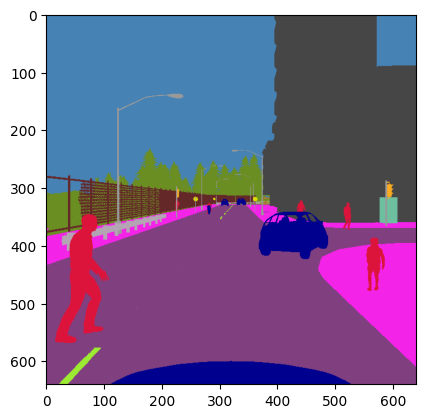

In [28]:
# Set the path to your semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Apply the boundary blur with the desired radius
image = apply_boundary_blur(image_path, blur_radius=1)

# Let's view the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

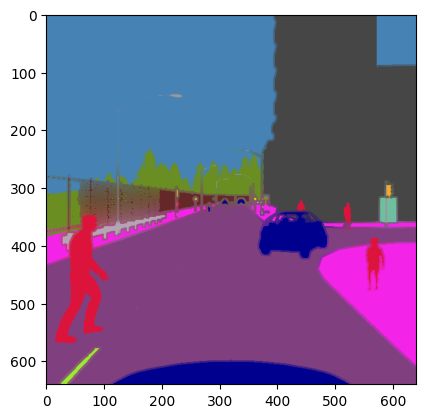

In [31]:
# Set the path to your semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Apply the boundary blur with the desired radius
image = apply_boundary_blur(image_path, blur_radius=149)

# Let's view the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [1]:
import cv2
import numpy as np

def create_transition_zones(label_image, transition_width):
    """
    Identify boundary pixels and create transition zones between classes.
    """
    # Copy the label image to work on
    transition_image = np.copy(label_image)
    
    # Identify boundaries and dilate them
    edges = cv2.Canny(label_image, 100, 200)
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=transition_width)
    
    # Set the boundary pixels to a special value indicating a transition zone
    transition_image[dilated_edges > 0] = -1  # Assuming no class label is -1
    
    return transition_image

def reassign_transition_labels(transition_image, original_labels):
    """
    Reassign the transition pixels to valid class labels.
    """
    # Identify pixels in the transition zones
    transition_pixels = np.where(transition_image == -1)
    
    for pixel in zip(transition_pixels[0], transition_pixels[1]):
        # Get the neighborhood of the pixel
        neighborhood = transition_image[pixel[0]-1:pixel[0]+2, pixel[1]-1:pixel[1]+2]
        
        # Find the most common label in the neighborhood
        unique, counts = np.unique(neighborhood, return_counts=True)
        most_common_label = unique[np.argmax(counts)]
        
        # Reassign the pixel to the most common label
        transition_image[pixel] = most_common_label
    
    return transition_image



In [13]:
depth_paths = ['test_data/attention_t01_route00_clearnoon/depth_central000517.png']
semantic_segmentation_paths = ['test_data/attention_t01_route00_clearnoon/ss_central000517.png']


In [14]:
from dataloaders import transforms

*_, mask_merge_central = transforms.get_virtual_attention_map(
        depth_path=depth_paths[0],
        segmented_path=semantic_segmentation_paths[0],
        depth_threshold=20.0,
        min_depth=2.3,
        central_camera=True
    )

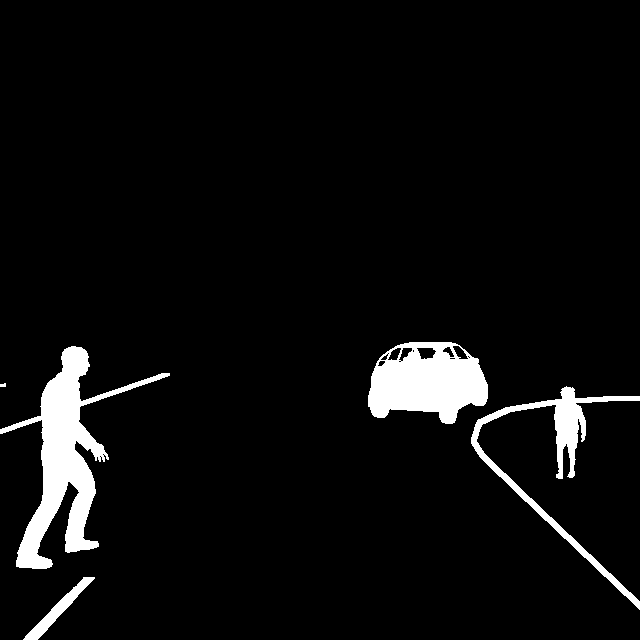

In [16]:
from PIL import Image

Image.fromarray(mask_merge_central)

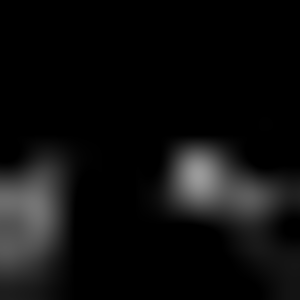

In [17]:
resized_mask_merge_central = cv2.resize(mask_merge_central, (10, 10), interpolation=cv2.INTER_AREA)
resized_mask_merge_central = cv2.resize(resized_mask_merge_central, (300, 300), interpolation=cv2.INTER_CUBIC)

Image.fromarray(resized_mask_merge_central)

In [1]:
og_ss_img = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)
ss_img = cv2.resize(og_ss_img, (10, 10), interpolation=cv2.INTER_CUBIC)
ss_img = cv2.resize(ss_img, (300, 300), interpolation=cv2.INTER_CUBIC)
# ss_img = cv2.cvtColor(ss_img, cv2.COLOR_BGR2RGB)

Image.fromarray(ss_img)

NameError: name 'cv2' is not defined

In [55]:
# Get the original classes (specific RGB values in the image)
original_classes = np.unique(og_ss_img.reshape(-1, og_ss_img.shape[-1]), axis=0)

# For every pixel in the resized semantic segmentation image,
# find the class in the original image that is closest in RGB space
# and assign that class to the pixel. Note the image has 3 channels!
resized_ss_img = np.zeros_like(ss_img)
for i in range(resized_ss_img.shape[0]):
    for j in range(resized_ss_img.shape[1]):
        pixel = ss_img[i, j][None, :]
        distances = np.linalg.norm(original_classes - pixel, axis=1)
        closest_class = original_classes[np.argmin(distances)]
        resized_ss_img[i, j] = closest_class

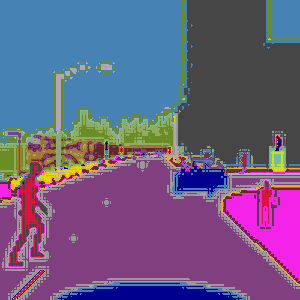

In [56]:
resized_ss_img = cv2.cvtColor(resized_ss_img, cv2.COLOR_BGR2RGB)

Image.fromarray(resized_ss_img)

In [65]:
depth_rgb, segmentation = transforms.read_images(depth_paths[0], semantic_segmentation_paths[0])
depth_img = transforms.process_depth_image(depth_rgb)

*_, imperfect_masks = transforms.create_masks(
    depth_img=depth_img,
    segmentation=segmentation,
    depth_threshold=20.0,
    min_depth=2.3,
    central_camera=True,
    converter=transforms.SS_CONVERTER
)

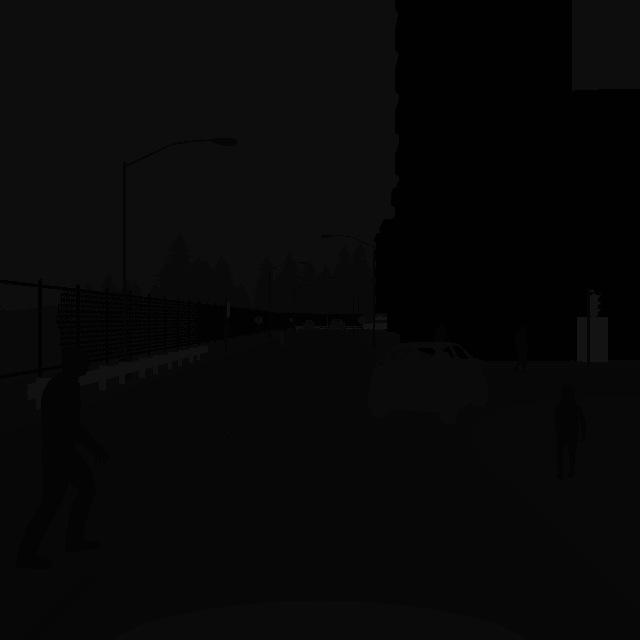

In [71]:
Image.fromarray(segmentation)

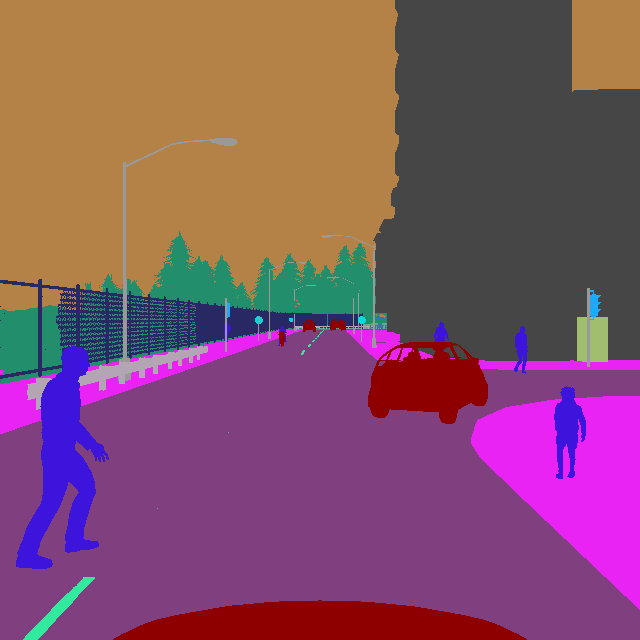

In [69]:
segmented_img = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)

Image.fromarray(segmented_img)

## Voronoi Semantic Segmentation

Another idea is to uniformly sample $N$ points from the image, see their actual class from the original semantic segmentation image, then do a Voronoi tesselation. This way, we corrupt the SS images and obtain a more "standard" semantic segmentation. 

In [1]:
import numpy as np
import cv2
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

def create_voronoi_segmentation(image_path, num_points):
    # Load the original segmentation image
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Sample points uniformly
    points = np.random.rand(num_points, 2)
    points[:, 0] *= width
    points[:, 1] *= height
    points = points.astype(int)

    # Get class labels for each point
    labels = [image[p[1], p[0]] for p in points]

    # Compute the Voronoi diagram for the points
    vor = Voronoi(points)

    # Create an empty canvas for the Voronoi segmentation
    voronoi_segmentation = np.zeros_like(image)

    # Iterate over Voronoi regions
    for region, label in zip(vor.regions, labels):
        if not -1 in region:  # Ignore regions that extend beyond the diagram
            polygon = [vor.vertices[i] for i in region]
            cv2.fillPoly(voronoi_segmentation, np.array([polygon], dtype=np.int32), color=label)

    return voronoi_segmentation

In [2]:
# Path to your RGB semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Number of points to sample
num_points = 1000  # Adjust this number as needed

# Create Voronoi segmentation
voronoi_image = create_voronoi_segmentation(image_path, num_points)

TypeError: Scalar value for argument 'color' is not numeric

In [11]:

def draw_points_on_image(image_path, num_points, save: bool = False):
    # Load the original segmentation image
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Sample points uniformly
    points = np.random.rand(num_points, 2) * np.array([width, height])
    points = points.astype(int)

    # Create a copy of the original image to draw the points
    points_image = image.copy()

    # Draw the points on the image
    for point in points:
        cv2.circle(points_image, center=tuple(point), radius=2, color=(0, 255, 0), thickness=-1)

    # Save the points image
    if save:
        points_image_path = 'points_' + image_path.split('/')[-1]
        cv2.imwrite(points_image_path, points_image)
        return points_image_path, points, points_image

    return points, points_image

In [12]:
image = cv2.imread(image_path)
num_points = 100

points, points_image = draw_points_on_image(image_path, num_points, save=False)

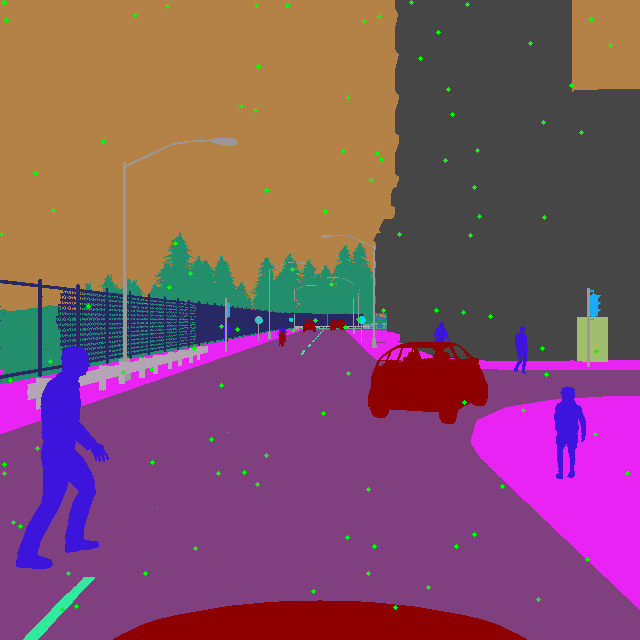

In [14]:
from PIL import Image
Image.fromarray(points_image)

In [15]:
# From these points, we can create a Voronoi diagram

# Compute the Voronoi diagram for the points
vor = Voronoi(points)

# Create an empty canvas for the Voronoi segmentation
voronoi_segmentation = np.zeros_like(image)

# Iterate over Voronoi regions
# for region, label in zip(vor.regions, labels):
#     if not -1 in region:  # Ignore regions that extend beyond the diagram
#         polygon = [vor.vertices[i] for i in region]
#         cv2.fillPoly(voronoi_segmentation, np.array([polygon], dtype=np.int32), color=label)

# Image.fromarray(voronoi_segmentation)

In [23]:
image[0][0]

array([180, 130,  70], dtype=uint8)

In [27]:
# Get class labels for each point
labels = [image[p[1], p[0]] for p in points]

len(labels)

100

In [16]:


# Compute the Voronoi diagram for the points
vor = Voronoi(points)

# Create an empty canvas for the Voronoi segmentation
voronoi_segmentation = np.zeros_like(image)

# Iterate over Voronoi regions
for region, label in zip(vor.regions, labels):
    if not -1 in region:  # Ignore regions that extend beyond the diagram
        polygon = [vor.vertices[i] for i in region]
        cv2.fillPoly(voronoi_segmentation, np.array([polygon], dtype=np.int32), color=label)